In [131]:
import pandas as pd
import pylab
import json
%matplotlib inline
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid') # TODO: what did this do?
import numpy as np
from IPython.core import display
import psycopg2
import os
homedir = os.getenv("HOME")
with open(homedir + "/.pgpass",'r') as pgfile:
    pgdat = pgfile.read().strip().split(":")
    pgurl = pgdat[0]
    pgport = pgdat[1]
    pgdb = pgdat[2]
    pguser = pgdat[3]
    pgpass = pgdat[4]

%load_ext sql
from sqlalchemy import create_engine
# sql info: https://github.com/catherinedevlin/ipython-sql
# on error `pip install ipython-sql`
#uncomment for remote
#pgport=3333
pgport=5433
engine = create_engine('postgresql://postgres@localhost:%i/postgres' % pgport)
db = psycopg2.connect(host=pgurl, database=pgdb, user=pguser,password=pgpass,port=pgport)

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [132]:
def qry(q):
  return pd.read_sql_query(con = db, sql = q)
# pd.set_option("max_colwidth", None)
# pd.set_option('display.max_columns', None)
pd.set_option("display.latex.repr", False)
pd.set_option("display.latex.escape", True)

def iDisplay(v):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, "max_colwidth", None):
        display.display(v)


Count number of uploaded APK files

In [133]:
%%sql postgresql://postgres@localhost:$pgport/postgres
select count(*) from apks where apkname not like 'jar_%' and apkname not like 'spec_%';

1 rows affected.


count
0


In [139]:
%%sql
select
    (select count(*) from apks) as apk_count, 
    (select count(*) from inputs) as input_count, 
    (select count(*) from jobs) as job_count, 
    (select count(*) from resultdata) as result_data_count, 
    (select count(*) from results) as result_count

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


apk_count,input_count,job_count,result_data_count,result_count
5,1,23,1,1


Print jobs and statuses

In [188]:
%%sql
select 
    (select count(*) from jobs where status = 'completed') as Completed_Jobs,
    (select count(*) from jobs where status = 'paused') as Paused_Jobs,
    (select count(*) from jobs where status = 'acquired') as Acquired_jobs,
    (select count(id) from jobs 
       where stderr like '%Exception%no active body present for method%') as Body_Exception,
    (select count(id) from jobs where stderr like '%an implementation is missing%') as unimplemented,
    (select count(id) from jobs where stderr like '%Exception%') as Exception,
    (select count(id) from jobs where stderr like '%no libz3java in java.library.path%') as path_exception,
    (select count(id) from jobs where stderr like '%Failed to parse reflective type reference%') as Refl_exception,
    (select count(id) from jobs where status like 'failed%') as worker_failure,
    (select count(id) from jobs where stdout like '%empty pred location%') as possible_cg_unsound,
    (select count(*) from jobs) as Total_Jobs

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


completed_jobs,paused_jobs,acquired_jobs,body_exception,unimplemented,exception,path_exception,refl_exception,worker_failure,possible_cg_unsound,total_jobs
23,0,0,0,0,0,0,0,0,0,23


In [142]:
# find exceptions
#%%sql 
#select replace(cast(stderr as varchar),'$','\$') from jobs where stderr like '%Exception%' limit 1;
out = %sql select stderr,config from jobs where stderr like '%Exception%' order by random() limit 1;
if(len(out) != 0):
    print(out[0][1])
    print(out[0][0])
else:
    print("none")


 * postgresql://postgres@localhost:5433/postgres
0 rows affected.
none


In [143]:
# find exceptions
#%%sql 
#select replace(cast(stderr as varchar),'$','\$') from jobs where stderr like '%Exception%' limit 1;
out = %sql select stderr,config from jobs where stderr like '%an implementation is missing%' order by random() limit 1;
if(len(out) != 0):
    print(out[0][1])
    print(out[0][0])
else:
    print("none")


 * postgresql://postgres@localhost:5433/postgres
0 rows affected.
none


Get failing apks

In [144]:
%%sql
select cast(config::json->'apkPath' as text) from jobs 
        where stderr like '%Exception%' group by cast(config::json->'apkPath' as text) ;

 * postgresql://postgres@localhost:5433/postgres
0 rows affected.


text


In [145]:
%%sql
select cast(config::json->'apkPath' as text) as app,count(*) as count from jobs group by app order by count desc;

 * postgresql://postgres@localhost:5433/postgres
3 rows affected.


app,count
"""${baseDir}/AntennaPod/app/build/outputs/apk/free/debug/app-free-debug.apk""",12
"""${baseDir}/connectbot/app/build/outputs/apk/google/debug/app-google-debug.apk""",6
"""${baseDir}/sgtpuzzles/app/build/outputs/apk/debug/app-debug.apk""",5


In [163]:
%%sql
select count(*),status from jobs group by status;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


count,status
23,completed


In [149]:
%%sql 
select cast(result::json->'summary' as varchar) as summary, cast(result::json->'maxPathCh' as varchar) as ch,count(*),avg(querytime),max(querytime) from results group by summary,ch order by summary,ch;

 * postgresql://postgres@localhost:5433/postgres
3 rows affected.


summary,ch,count,avg,max
"""\""Itimeout\""""","""\""UnknownCharacterization\""""",10,601.0000000000000000,601
"""\""Unreachable\""""","""\""UnknownCharacterization\""""",3,0.33333333333333333333,1
"""\""Witnessed\""""","""\""UnknownCharacterization\""""",24,3.5833333333333333,77


In [185]:
%%sql 
select regexp_substr(cast(jobs.config::json->'apkPath' as varchar), 'AntennaPod|connectbot|sgtpuzzles') as benchmark, 
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute') as isDismiss, 
    count(*)
    from results inner join jobs on results.jobid=jobs.id 
    group by regexp_substr(cast(jobs.config::json->'apkPath' as varchar), 'AntennaPod|connectbot|sgtpuzzles'),
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute')

 * postgresql://postgres@localhost:5433/postgres
4 rows affected.


benchmark,isdismiss,count
AntennaPod,Dialog_dismiss,26
connectbot,Dialog_dismiss,4
connectbot,execute,2
sgtpuzzles,Dialog_dismiss,17


In [182]:
%%sql 
select regexp_substr(cast(jobs.config::json->'apkPath' as varchar), 'AntennaPod|connectbot|sgtpuzzles') as benchmark, 
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute') as isDismiss, 
    cast(results.result::json->'summary' as varchar) as summary, count(*)
    from results inner join jobs on results.jobid=jobs.id 
    group by cast(jobs.config::json->'apkPath' as varchar),cast(results.result::json->'summary' as varchar),
    regexp_substr(cast(results.qry::json->'s' as varchar), 'Dialog_dismiss|execute')


 * postgresql://postgres@localhost:5433/postgres
10 rows affected.


benchmark,isdismiss,summary,count
AntennaPod,Dialog_dismiss,"""\""Itimeout\""""",14
AntennaPod,Dialog_dismiss,"""\""Witnessed\""""",12
connectbot,Dialog_dismiss,"""\""Itimeout\""""",1
connectbot,execute,"""\""Itimeout\""""",1
connectbot,Dialog_dismiss,"""\""Unreachable\""""",1
connectbot,execute,"""\""Unreachable\""""",1
connectbot,Dialog_dismiss,"""\""Witnessed\""""",2
sgtpuzzles,Dialog_dismiss,"""\""Itimeout\""""",4
sgtpuzzles,Dialog_dismiss,"""\""Unreachable\""""",1
sgtpuzzles,Dialog_dismiss,"""\""Witnessed\""""",12


In [179]:
%%sql
select id from results where cast(results.result::json->'summary' as varchar) like '%Witnessed%'

 * postgresql://postgres@localhost:5433/postgres
26 rows affected.


id
67471
67472
67473
67475
67476
67477
67479
67480
67481
67483


In [178]:
cfg = %sql select jobs.config from results inner join jobs on results.jobid=jobs.id where cast(results.result::json->'summary' as varchar) like '%Witnessed%' limit 1;
cfg[0][0]

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


'{"apkPath":"${baseDir}/connectbot/app/build/outputs/apk/google/debug/app-google-debug.apk","outFolder":["${baseDirOut}/org.connectbot"],"specSet":"{\\"specs\\":[],\\"disallow\\":[{\\"univQuant\\":[{\\"$type\\":\\"edu.colorado.plv.bounder.symbolicexecutor.state.NamedPureVar\\",\\"n\\":\\"d\\"}],\\"existQuant\\":[{\\"$type\\":\\"edu.colorado.plv.bounder.symbolicexecutor.state.NamedPureVar\\",\\"n\\":\\"a\\"}],\\"pred\\":{\\"$type\\":\\"edu.colorado.plv.bounder.lifestate.LifeState.And\\",\\"l1\\":{\\"$type\\":\\"edu.colorado.plv.bounder.lifestate.LifeState.OAbsMsg\\",\\"mt\\":{\\"$type\\":\\"edu.colorado.plv.bounder.ir.CIExit\\"},\\"signatures\\":{\\"$type\\":\\"edu.colorado.plv.bounder.lifestate.LifeState.SubClassMatcher\\",\\"baseSubtypeOf\\":[\\"android.app.ProgressDialog\\",\\"android.app.Dialog\\"],\\"signatureMatcher\\":\\".*show.*\\",\\"ident\\":\\"Dialog_show\\"},\\"lsVars\\":[{\\"$type\\":\\"edu.colorado.plv.bounder.symbolicexecutor.state.NamedPureVar\\",\\"n\\":\\"d\\"},{\\"$ty

In [ ]:
%%sql
select id,cast(result::json->'summary' as varchar) as summary,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results order by random() limit 5;

Triage witness results
----------------------

In [186]:
witnessesq = %sql \
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results \
                where cast(result::json->'summary' as varchar) like '%Witnessed%' order by id asc;

witnessesdf = witnessesq.DataFrame()
witnessesdf.to_csv('triageWit.csv')

 * postgresql://postgres@localhost:5433/postgres
26 rows affected.


In [187]:
witnessesq = %sql \
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results \
                where cast(result::json->'summary' as varchar) like '%Itimeout%' and cast(result::json->'maxPathCh' as varchar) like '%MultiCallback%' order by id asc;

witnessesdf = witnessesq.DataFrame()
witnessesdf.to_csv('triageWitMultiTimeout.csv')

 * postgresql://postgres@localhost:5433/postgres
0 rows affected.


In [ ]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'line'->'str' as varchar),'$','\$') from results where id = 40;

Triage proven results
--------------------------

In [ ]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz,loc::json->'method'->>2 from results 
                where cast(result::json->'summary' as varchar) like '%Proven%' order by random() limit 10;

Triage unreachable results
--------------------------

In [ ]:
%%sql 
select id,jobid,resultdata,loc::json->'method'->>1 as clazz 
            from results where cast(result::json->'summary' as varchar) like '%Unreachable%' 
            order by random() limit 15;

In [ ]:
%%sql
select id,jobid,resultdata,loc::json->'method'->>1 as clazz, 
        replace(cast(loc::json->'method'->>0 as varchar),'$','\$') as mname, 
        replace(cast(loc::json->'line' as varchar),'$','\$') as location 
        from results where id = 15037;

In [ ]:
%%sql
select id,result,replace(cast(loc::json->'line' as varchar),'$','\$') as location 
    from results where loc like '%244 $r3%';

In [ ]:
%%sql
select replace(cast(loc as varchar),'$','\$') from results where id = 1494;

Runtime Stats
=============

 * postgresql://postgres@localhost:5433/postgres
36900 rows affected.


Text(0.5, 0, 'time (sec)')

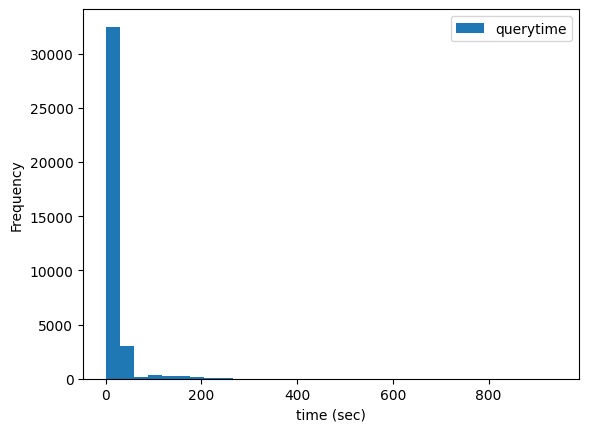

In [108]:
queryTime = %sql select querytime from results;
tplt = queryTime.DataFrame().plot.hist(bins=32)
# tplt.set_yscale('log')
tplt.set_xlabel('time (sec)')
# split this into proven and witnessed

 * postgresql://postgres@localhost:5433/postgres
1665 rows affected.


Text(0.5, 0, 'time (min)')

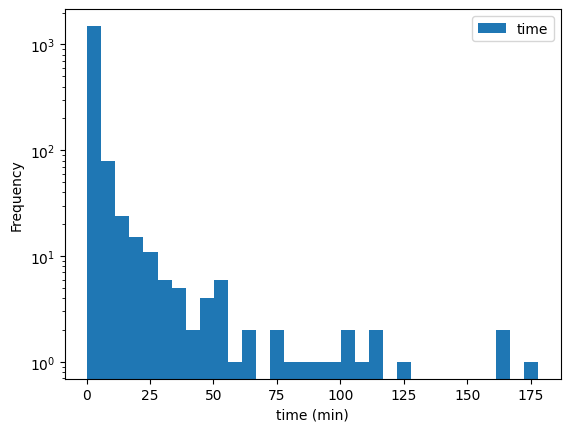

In [109]:
# Job runtimes
runtimes = %sql select ended - started as time from jobs where ended is not NULL;
runtimesDF = runtimes.DataFrame()
runtimesDF['time'] = runtimesDF['time'].apply(lambda x: x.total_seconds() / (60))
tplt = runtimesDF.plot.hist(bins=32)
tplt.set_yscale('log')
tplt.set_xlabel('time (min)')

 * postgresql://postgres@localhost:5433/postgres
1921 rows affected.


/tmp/ipykernel_8113/1841651425.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.plot_date(rtvtDF['started'], rtvtDF['time'], marker='*', linestyle='')


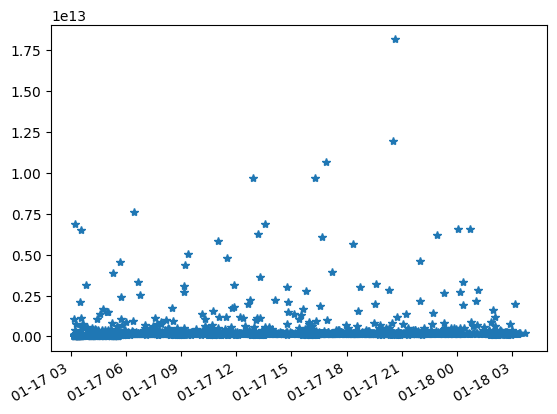

In [125]:
# Plot job time trend
rtvt = %sql select started, ended - started as time from jobs where ended is not NULL;
rtvtDF = rtvt.DataFrame()
rtvtDF.sort_values('started', ascending=True)
fig, ax = plt.subplots()
ax.plot_date(rtvtDF['started'], rtvtDF['time'], marker='*', linestyle='')

fig.autofmt_xdate()
plt.show()


Total job time

In [111]:
%%sql
select sum(ended-started) from jobs where ended is not NULL;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


sum
"5 days, 8:32:38.636000"


In [112]:
%%sql
select sum(querytime)/60./60. from results;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


?column?
80.5844444444444444


In [128]:
%%sql
select now() - min(started) from jobs;

 * postgresql://postgres@localhost:5433/postgres
1 rows affected.


?column?
"1 day, 13:54:09.010372"


Size of postgres data
=====================

In [76]:
%%sql
WITH RECURSIVE pg_inherit(inhrelid, inhparent) AS
    (select inhrelid, inhparent
    FROM pg_inherits
    UNION
    SELECT child.inhrelid, parent.inhparent
    FROM pg_inherit child, pg_inherits parent
    WHERE child.inhparent = parent.inhrelid),
pg_inherit_short AS (SELECT * FROM pg_inherit WHERE inhparent NOT IN (SELECT inhrelid FROM pg_inherit))
SELECT table_schema
    , TABLE_NAME
    , row_estimate
    , pg_size_pretty(total_bytes) AS total
    , pg_size_pretty(index_bytes) AS INDEX
    , pg_size_pretty(toast_bytes) AS toast
    , pg_size_pretty(table_bytes) AS TABLE
  FROM (
    SELECT *, total_bytes-index_bytes-COALESCE(toast_bytes,0) AS table_bytes
    FROM (
         SELECT c.oid
              , nspname AS table_schema
              , relname AS TABLE_NAME
              , SUM(c.reltuples) OVER (partition BY parent) AS row_estimate
              , SUM(pg_total_relation_size(c.oid)) OVER (partition BY parent) AS total_bytes
              , SUM(pg_indexes_size(c.oid)) OVER (partition BY parent) AS index_bytes
              , SUM(pg_total_relation_size(reltoastrelid)) OVER (partition BY parent) AS toast_bytes
              , parent
          FROM (
                SELECT pg_class.oid
                    , reltuples
                    , relname
                    , relnamespace
                    , pg_class.reltoastrelid
                    , COALESCE(inhparent, pg_class.oid) parent
                FROM pg_class
                    LEFT JOIN pg_inherit_short ON inhrelid = oid
                WHERE relkind IN ('r', 'p')
             ) c
             LEFT JOIN pg_namespace n ON n.oid = c.relnamespace
  ) a
  WHERE oid = parent
) a
ORDER BY total_bytes DESC limit 5;

 * postgresql://postgres@localhost:5433/postgres
5 rows affected.


table_schema,table_name,row_estimate,total,index,toast,table
public,apks,0.0,98 MB,0 bytes,98 MB,24 kB
public,results,3701.0,5168 kB,264 kB,424 kB,4480 kB
public,resultdata,178.0,3128 kB,64 kB,2936 kB,128 kB
public,jobs,2226.0,1336 kB,192 kB,112 kB,1032 kB
pg_catalog,pg_proc,3244.0,1192 kB,336 kB,56 kB,800 kB


Inspection of exceptions
========================

In [ ]:
%%sql
select id,config::json->'apkPath',replace(stderr,'$','\$') from jobs where stderr like '%Exception%';

In [ ]:
#count of total results
%sql select count(*) as Total_locations_computed from results